In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.6 MB/s 
     |████████████████████████████████| 163 kB 51.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.6 MB/s 


In [4]:
import torch
import numpy as np
import pandas as pd
import time
import datetime
import random
import os


from tqdm.notebook import tqdm
from copy import deepcopy
from torch.utils.data import TensorDataset,DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import BertForSequenceClassification,BertTokenizer,get_linear_schedule_with_warmup,DataCollatorWithPadding

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files



In [9]:
def get_model_1_dataset(dfInput):
  df = deepcopy(dfInput)
  df.loc[df["label"] == 2, "label"] = 1
  return df

def get_model_2_dataset(dfInput):
  df = deepcopy(dfInput)
  aman = df[df['label']==0]
  df = df.drop(aman.index)
  df.loc[df["label"] == 1, "label"] = 0
  df.loc[df["label"] == 2, "label"] = 1
  return df

In [8]:
def add_data_type(df):
  df['data_type'] = ['not_set']*df.shape[0]
  X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                    df.label.values, 
                                                    test_size=0.30, 
                                                    random_state=42, 
                                                    stratify=df.label.values)
  df.loc[X_train, 'data_type'] = 'train'
  df.loc[X_test, 'data_type'] = 'test'
  X_train, X_val, y_train, y_val = train_test_split(df[df.data_type=='train'].index.values, 
                                                    df[df.data_type=='train'].label.values, 
                                                    test_size=0.30, 
                                                    random_state=42, 
                                                    stratify=df[df.data_type=='train'].label.values)

  df.loc[X_val, 'data_type'] = 'val'
  return df

In [10]:
dfOri = pd.read_csv('/content/drive/MyDrive/Kuliah/Skripsi/data+label+extended-v2.csv')
dfOri = dfOri.dropna(how='any',axis=0)

undersampling = 1450

aman = dfOri[dfOri['label']==0]
ragu = dfOri[dfOri['label']==1]
beresiko = dfOri[dfOri['label']==2]

aman_undersampling = aman.sample(n=undersampling, random_state=101)
df = pd.concat([aman_undersampling,ragu,beresiko],axis=0)
df = add_data_type(df)


In [11]:
df

,id,essay,label,data_type
2521,2522,I've ever been affected by covid-19 in last Ju...,0,train
3771,3772,"Generally speaking, there are six aspects of h...",0,test
3138,3139,"For my entire life(19 years)thanks to God,I ha...",0,val
356,357,I am fortunate enough to not have gone through...,0,train
2196,2197,"I‚Äôm a healthy person, so I don‚Äôt have medi...",0,test
...,...,...,...,...
4212,4213,"Well, I'm grateful that I have good mental hea...",2,train
4213,4214,"In the last two years, I got diagnosed with si...",2,val
4217,4218,In 2021 is my hardest year. I was diagnosed wi...,2,train
4218,4219,I would say that my overall health is great be...,2,test


In [ ]:
print('before under sampling : ')
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
print(df.label.value_counts())

df_model_1 = get_model_1_dataset(df)
df_model_2 = get_model_2_dataset(df)

print('\nNumber of training sentences model 1: {:,}\n'.format(df_model_1.shape[0]))
print(df_model_1.label.value_counts())
print('\nNumber of training sentences model 2: {:,}\n'.format(df_model_2.shape[0]))
print(df_model_2.label.value_counts())

before under sampling : 
Number of training sentences: 2,304

0    1450
1     682
2     172
Name: label, dtype: int64

Number of training sentences model 1: 2,304

0    1450
1     854
Name: label, dtype: int64

Number of training sentences model 2: 854

0    682
1    172
Name: label, dtype: int64


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
 tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
 encoded_data = tokenizer.batch_encode_plus(
      data.essay.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding='max_length',
      max_length=512, 
      return_tensors='pt',
      truncation=True
  )

In [ ]:
def create_dataloader(data,tokenizer, samplerFunction = SequentialSampler):
  batch_size = 16
  encoded_data = tokenizer.batch_encode_plus(
      data.essay.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding='max_length',
      max_length=512, 
      return_tensors='pt',
      truncation=True
  )
  input_ids = encoded_data['input_ids']
  attention_masks = encoded_data['attention_mask']
  labels = torch.tensor(data.label.values)

  dataset= TensorDataset(input_ids, attention_masks, labels)
  return DataLoader(dataset, 
            sampler=samplerFunction(dataset), 
            batch_size=batch_size)

In [ ]:
def split_dataset(df):
  data_train = df[df.data_type=='train']
  data_validation = df[df.data_type=='val']
  data_test = df[df.data_type=='test']
  return data_train,data_validation,data_test

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

data_train_model_1,data_validation_model_1,_ = split_dataset(df_model_1)
data_train_model_2,data_validation_model_2,_ = split_dataset(df_model_2)

data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
def get_model(label_dict):
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      )
  model.config.hidden_dropout_prob=0.45
  model.config.attention_probs_dropout_prob=0.45
  model.cuda()
  return model

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels,label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def get_class_weights(labels):
  #compute the class weights
  weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels),y=labels)
  class_weights= torch.tensor(weights,dtype=torch.float)
  class_weights = class_weights.to(device)
  return class_weights

In [ ]:
def get_optimizer(model, learningRate):
  return  AdamW(model.parameters(),
                lr = learningRate,
                eps=1e-8)

In [ ]:
def get_scheduler(num_training_steps, optimizer):
  return get_linear_schedule_with_warmup(optimizer,
                                         num_warmup_steps=0,
                                         num_training_steps=num_training_steps)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
def save_model(filename, output_dir, model):
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)
  torch.save(model.state_dict(),f'{output_dir}/{filename}')

In [ ]:
def evaluate(dataloader,modelToTest,epoch,class_weights):

    modelToTest.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    # Tracking variables 
    accuracy_val_total = 0
    progress_bar = tqdm(dataloader,
                        desc='Epoch Eval {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = modelToTest(**inputs)
            
        logits = outputs[1]
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = criterion(logits, batch[2])
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()

        accuracy_val_total += flat_accuracy(logits, label_ids)

        predictions.append(logits)
        true_vals.append(label_ids)
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    loss_val_avg = loss_val_total/len(dataloader) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    avg_val_accuracy = accuracy_val_total / len(dataloader)

    return loss_val_avg, predictions, true_vals,avg_val_accuracy

In [ ]:
def test(dataloader,modelToTest):

    modelToTest.eval()
    predictions = []
    progress_bar = tqdm(dataloader,
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = modelToTest(**inputs)

        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()


        predictions.append(logits)
    
    predictions = np.concatenate(predictions, axis=0)

    return predictions

In [ ]:
def train_and_validate(learning_rate,dataset_train,dataset_validation,epochs,model_type, label_dict):
  total_t0 = time.time()
  training_stats = []
  best_loss = 1;
  best_loss_epoch = 0
  best_model_path = ""

  dataloader_train = create_dataloader(dataset_train,tokenizer,RandomSampler)
  dataloader_validation =  create_dataloader(dataset_validation,tokenizer)

  iterator_epoch = tqdm(range(1, epochs+1),
                        desc='Train learning rate-{:1f}'.format(learning_rate))
  
  num_training_steps = len(dataloader_train)*epochs
  model = get_model(label_dict)
  optimizer = get_optimizer(model,learning_rate) 
  scheduler = get_scheduler(num_training_steps, optimizer)
  class_weights = get_class_weights(dataset_train.label.to_numpy())
  validation_class_weights = get_class_weights(dataset_validation.label.to_numpy())
  output_dir = f'./model/{model_type}/{learning_rate}'
  
  MAX_EPOCH_OVER_FITTING = 2
  prev_loss = 0;
  overfitting_epoch_count = 0

  for epoch in iterator_epoch:

      if(overfitting_epoch_count + 1 > MAX_EPOCH_OVER_FITTING ) :
        print('break because overfitting')
        iterator_epoch.close()
        break

      t0 = time.time()
      model.train()
      loss_train_total = 0
      progress_bar = tqdm(dataloader_train, 
                          desc='Train Epoch-{:1d}'.format(epoch), 
                          leave=False, 
                          disable=False)
      

      for batch in progress_bar:
          model.zero_grad()
          
          batch = tuple(b.to(device) for b in batch)
          
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                  }       

          outputs = model(**inputs)
          logits = outputs[1]
          
          criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
          loss = criterion(logits, batch[2])
          loss_train_total += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

      training_time = format_time(time.time() - t0)
      loss_train_avg = loss_train_total/len(dataloader_train)
      
      filename = f'model_{epoch}.model'
      save_model(filename,output_dir, model)
      t0 = time.time()
      val_loss, predictions, true_vals,accuracy = evaluate(dataloader_validation,model, epoch,validation_class_weights )
      validation_time = format_time(time.time() - t0)
      val_f1 = f1_score_func(predictions, true_vals)
      training_stats.append(
          {
              'epoch': epoch,
              'Training Loss': loss_train_avg,
              'Valid. Loss': val_loss,
              'Accuracy' : accuracy,
              'Validation Time' : validation_time,
              'Training Time': training_time
          }
      )      
      tqdm.write(f'\nEpoch {epoch}')
      tqdm.write(f'Training loss: {loss_train_avg}')
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'F1 Score (Weighted): {val_f1}')
      tqdm.write(f'Training epcoh took: {training_time}')
      tqdm.write(f'Validation epcoh took: {validation_time}')
      tqdm.write(f'overfitting_epoch_count: {overfitting_epoch_count}')

      if(val_loss < best_loss):
        best_loss = val_loss
        best_loss_epoch = epoch
        path = f'{output_dir}/{filename}'
        best_model_path=path
        overfitting_epoch_count = 0
      elif(val_loss > prev_loss):
        overfitting_epoch_count += 1
      else:
        overfitting_epoch_count = 1

      prev_loss=val_loss

  return {
      'best_loss_epoch':best_loss_epoch, 
      'best_loss':best_loss, 
      'epochs':epochs, 
      'training_stats':training_stats,
      'best_model_path':best_model_path,
  }


In [ ]:
def show_lerning_rate_graph(training_stats):
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=training_stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')
  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  # plt.xticks([1, 2, 3, 4])

  plt.show()

In [ ]:
def get_model_data(data_train,data_validation,label_dict, model_type):
  best_loss = 1;
  best_loss_epoch = 0
  best_loss_learning_rate = 0
  best_training_stats = []
  best_model_path=""

  max_learning_rate = 5e-5
  current_learning_rate = 1e-5
  epochs = 9

  while(current_learning_rate < max_learning_rate):
    training_result = train_and_validate(current_learning_rate,
                                        data_train,
                                        data_validation,
                                        epochs,
                                        model_type,
                                        label_dict)
    
    if(training_result['best_loss'] < best_loss):
      best_loss = training_result['best_loss']
      best_loss_epoch = training_result['best_loss_epoch']
      best_training_stats = training_result['training_stats']
      best_model_path = training_result['best_model_path']
      best_loss_learning_rate = current_learning_rate

    current_learning_rate += 5e-6
  
  return {
      'best_loss_epoch':best_loss_epoch, 
      'best_loss':best_loss, 
      'epochs':epochs, 
      'training_stats':best_training_stats,
      'best_model_path':best_model_path,
      'best_loss_learning_rate' : best_loss_learning_rate
  }

In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_result_model_1 = get_model_data(data_train_model_1,
                                         data_validation_model_1,
                                         label_dict_model_1, 
                                         'model_1')
training_result_model_2 = get_model_data(data_train_model_2,
                                         data_validation_model_2,
                                         label_dict_model_2, 
                                         'model_2')

In [ ]:
def show_stats_result(predictions,true_vals):
  val_pred = np.argmax(predictions, axis=-1)
  labels =["aman","meragukan","beresiko"]
  confusion_matrix = metrics.confusion_matrix(true_vals, val_pred)
  cm_display = metrics.ConfusionMatrixDisplay(
      confusion_matrix = confusion_matrix, 
      display_labels=labels,
      )
  report =metrics.classification_report(true_vals, val_pred, labels=[0,1])
  cm_display.plot()
  plt.show()
  print(report)

In [ ]:
# training_result_model_1 = train_and_validate(15e-6,data_train_model_1,data_validation_model_1,9,'model_1',label_dict_model_1)
# training_result_model_2 = train_and_validate(3e-5,data_train_model_2,data_validation_model_2,9,'model_2',label_dict_model_2)

In [ ]:
def load_model(path):
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_model_1),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
  model.to(device)
  model.load_state_dict(torch.load(path))
  return model

In [ ]:
# best_model_1_path = training_result_model_1['best_model_path']
# best_model_2_path = training_result_model_2['best_model_path']
best_model_1_path = "./model/model_1/1.5e-05/model_4.model"
best_model_2_path = "./model/model_2/3e-05/model_5.model"

In [ ]:
model_1 = load_model(best_model_1_path)
df_test = df[df['data_type']=='test']
data_test_1 = get_model_1_dataset(df_test)
dataloader_model_1_test =  create_dataloader(data_test_1,tokenizer)

predictions = test(dataloader_model_1_test,model_1)
pred_flat = np.argmax(predictions, axis=1).flatten()
df_test['preds'] = pred_flat

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/44 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_test[df_test['preds'] == 1]

,id,essay,label,data_type,preds
324,325,"As the phrase goes, “If you have good health, ...",0,test,1
878,879,"Hippocrates once said, ""Health is the greatest...",0,test,1
1935,1936,I have a skin condition called psoriasis. It i...,0,test,1
213,214,I have been prone to gastritis throughout my l...,0,test,1
334,335,I underwent Dental treatment for teeth cavity ...,0,test,1
...,...,...,...,...,...
4188,4189,There’s actually a small problem with both of ...,2,test,1
4202,4203,"As a person, I need to check my health conditi...",2,test,1
4206,4207,My Journey with PCOS started at the beginning ...,2,test,1
4210,4211,I consider myself a physically active person b...,2,test,1


In [ ]:
model_2 = load_model(best_model_2_path)
data_test_2 = deepcopy(df_test[df_test['preds'] == 1])
data_test_2 = get_model_2_dataset(data_test_2)
dataloader_model_2_test =  create_dataloader(data_test_2,tokenizer)

predictions = test(dataloader_model_2_test,model_2)
pred_flat = np.argmax(predictions, axis=1).flatten()
data_test_2['preds'] = pred_flat

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
data_test_2.loc[data_test_2["preds"] == 1, "preds"] = 2
data_test_2.loc[data_test_2["preds"] == 0, "preds"] = 1

In [ ]:
for index, row in data_test_2.iterrows():
    df_test.loc[df_test['id']==row['id'], 'preds'] = row['preds']

In [ ]:
def show_stats_result_2(val_pred,true_vals):
  labels =["aman","meragukan","beresiko"]
  confusion_matrix = metrics.confusion_matrix(true_vals, val_pred)
  cm_display = metrics.ConfusionMatrixDisplay(
      confusion_matrix = confusion_matrix, 
      display_labels=labels,
      )
  report =metrics.classification_report(true_vals, val_pred, labels=[0,1,2])
  plt.rcParams['figure.figsize'] = (9, 9)
  cm_display.plot()
  plt.show()
  print(report)

def accuracy_per_class_2(preds_flat, labels):
    label_dict = {
      'aman' : 0,
      'meragukan':1,
      'beresiko' : 2
    }
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    labels_flat = labels.flatten()
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

class: aman
Accuracy: 382/435

class: meragukan
Accuracy: 149/205

class: beresiko
Accuracy: 26/52



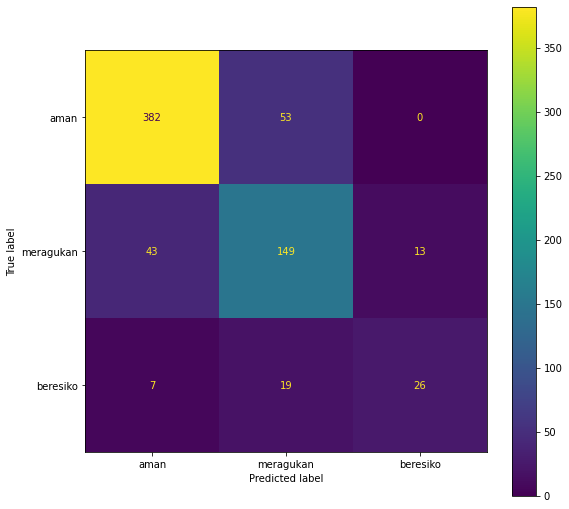

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       435
           1       0.67      0.73      0.70       205
           2       0.67      0.50      0.57        52

    accuracy                           0.80       692
   macro avg       0.74      0.70      0.72       692
weighted avg       0.81      0.80      0.80       692



In [ ]:
preds = df_test['preds'].to_numpy()
true_value = df_test['label'].to_numpy()
accuracy_per_class_2(preds,true_value)
show_stats_result_2(preds,true_value)

In [ ]:
# dfKosong = pd.read_csv('/content/drive/MyDrive/Kuliah/Skripsi/batch3.csv')
# dfKosong = dfKosong.dropna(how='any',axis=0)

# encoded_data_kosong = tokenizer.batch_encode_plus(
#     dfKosong.essay.values, 
#     add_special_tokens=True, 
#     return_attention_mask=True, 
#     padding='max_length',
#     max_length=512, 
#     return_tensors='pt',
#     truncation=True
# )

# input_ids_kosong = encoded_data_kosong['input_ids']
# attention_masks_kosong = encoded_data_kosong['attention_mask']
# labels_kosong = torch.tensor(dfKosong.label.values)

# dataset_kosong = TensorDataset(input_ids_kosong, attention_masks_kosong, labels_kosong)

# dataloader_kosong = DataLoader(dataset_kosong, 
#                                    sampler=SequentialSampler(dataset_kosong), 
#                                    batch_size=batch_size)

In [ ]:
# preds_flat = np.argmax(predictions, axis=1).flatten()
# newDf = pd.DataFrame(preds_flat)
# newDf.head()

In [ ]:
# print(newDf.shape)
# print(newDf.value_counts())

In [ ]:
# newDf.to_csv('predictions.csv') 
# files.download("predictions.csv")